In [1]:
import metadata
import os

basepath='/media/data/datasets/sign/rwth-boston-104'
basepath='/data/datasets/rwth-boston-104'






In [38]:
import numpy as np
import skimage.io as io
import skimage
import tensorflow as tf
from keras import backend as K



class Boston104LocalizationIterator(tf.keras.preprocessing.image.Iterator ):
    """Iterator yielding data from a Numpy array.
    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, base_path,localization_grid_shape,body_parts=['head'],
                 batch_size=32,shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        self.basepath=basepath
        
        self.localization_grid_shape=localization_grid_shape
        self.body_parts=body_parts
        
        self.sub_image=np.array([0,240,10,326])
        self.h,self.w=(self.sub_image[1]-self.sub_image[0],self.sub_image[3]-self.sub_image[2])
        
        self.video_positions_filepath=os.path.join(basepath,'handpositions/boston104.handpositions.rybach-forster-dreuw-2009-09-25.full.xml')
        self.images_path=os.path.join(basepath,'png-segments')
        self.frames=metadata.parse_videos_to_images(self.video_positions_filepath,self.images_path)
        
        #self.image_data_generator = image_data_generator
        
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        
        
        super(Boston104LocalizationIterator, self).__init__(len(self.frames), batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        print(index_array)
        batch_x,batch_y=self.read_boston104_frames(index_array[0])

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                
        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)
    
    def image_position_to_grid_position(self,grid_shape,image_shape,image_position):
        ratio=grid_shape/image_shape
        grid_position=np.round(image_position*ratio)
        
        return grid_position.astype(int)
    
    def read_boston104_frames(self,frame_indices):
        
        n=len(frame_indices)
        x=np.zeros((n,1,self.h,self.w))
        image_shape=np.array([self.h,self.w])
        y_dim=np.prod(self.localization_grid_shape)
        y=np.zeros((n,y_dim))
        
        w=self.sub_image
        for (i,j) in enumerate(frame_indices):
            frame=self.frames[j]
            image=io.imread(frame.path)
            image=image[w[0]:w[1],w[2]:w[3],:]
            image=skimage.color.rgb2grey(image)
#             image = self.image_data_generator.random_transform(image.astype(K.floatx()))
#             image = self.image_data_generator.standardize(image)
            x[i,0,:,:]=image
            for body_part in self.body_parts:
                image_position_point=frame.positions[body_part]
                image_position=np.array([image_position_point.y,image_position_point.x])
                grid_position=self.image_position_to_grid_position(self.localization_grid_shape,image_shape,image_position)
                flat_position=np.ravel_multi_index(grid_position, self.localization_grid_shape)
                y[i,flat_position]=1
        
            
        return x,y


localization_grid_shape=np.array([30,20])
# implement iterator like https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/pascal_voc.py    
iterator=Boston104LocalizationIterator(basepath,localization_grid_shape,body_parts=['head'],shuffle=True)



(array([ 2775, 13300, 14071,  3393, 10977, 10083,  6878,  4436, 10773,
       15066,  3873,  3899,  7836,  3959, 11522,  2366,  4997,  4172,
        5243,  8302,  4390,  2846,  9701,   901,  5371, 14675,  6754,
       13636,  7093,  6597,  6464,  1444]), 0, 32)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.

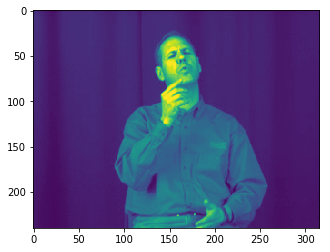

In [39]:
import matplotlib.pyplot as plt
batch_x,batch_y=iterator.next()
print(batch_y[0,:])
plt.imshow(batch_x[0,0,:,:])
print(np.where(batch_y[0,:]>0))
plt.show()

from keras.models import Sequential

model = Sequential()




